In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
#plt.rcParams.update({   "text.usetex": True,})


In [2]:
"""kvec = [1e-1, 1, 10]
cosmo = Class()
cosmo.set({'H0':70, 'Omega_b':0.05, 'Omega_cdm':0.25, 'k_output_values':str(kvec).strip('[]'), 
           'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
          'N_ncdm':1, 'm_ncdm':10, 'gauge':'synchronous'})
cosmo.compute()"""

"kvec = [1e-1, 1, 10]\ncosmo = Class()\ncosmo.set({'H0':70, 'Omega_b':0.05, 'Omega_cdm':0.25, 'k_output_values':str(kvec).strip('[]'), \n           'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',\n          'N_ncdm':1, 'm_ncdm':10, 'gauge':'synchronous'})\ncosmo.compute()"

In [3]:
"""bg = cosmo.get_background()
print(bg.keys())
a = 1/(1 + bg['z'])
tau = bg['conf. time [Mpc]']
plt.loglog(a, tau)
a_eq = cosmo.get_current_derived_parameters(['a_eq'])['a_eq']
plt.axvline(a_eq)
print(np.interp(a_eq, a, tau))

plt.figure()
plt.loglog(a, bg['gr.fac. D'])
"""

"bg = cosmo.get_background()\nprint(bg.keys())\na = 1/(1 + bg['z'])\ntau = bg['conf. time [Mpc]']\nplt.loglog(a, tau)\na_eq = cosmo.get_current_derived_parameters(['a_eq'])['a_eq']\nplt.axvline(a_eq)\nprint(np.interp(a_eq, a, tau))\n\nplt.figure()\nplt.loglog(a, bg['gr.fac. D'])\n"

In [4]:
"""pts = cosmo.get_perturbations()['scalar']
index_k = 1
pts0 = pts[index_k]
pts0['a']
print(pts0.keys())
for species in ['ur', 'cdm', 'b', 'ncdm[0]', 'g']:
    delta = pts0['delta_' + species]
    plt.loglog(pts0['tau [Mpc]'], -delta, label=species)
plt.legend()
plt.title(f'k = {kvec[index_k]} 1/Mpc')
"""

"pts = cosmo.get_perturbations()['scalar']\nindex_k = 1\npts0 = pts[index_k]\npts0['a']\nprint(pts0.keys())\nfor species in ['ur', 'cdm', 'b', 'ncdm[0]', 'g']:\n    delta = pts0['delta_' + species]\n    plt.loglog(pts0['tau [Mpc]'], -delta, label=species)\nplt.legend()\nplt.title(f'k = {kvec[index_k]} 1/Mpc')\n"

In [5]:
# all output er i newtonian gauge af historiske årsager du kan overveje at udkommetnere gaugetransformation i koden senere.

Så det er rent kaos herfra

$\ddot{D} +a H\dot{D} = \frac{3}{2} H^2 \Omega_m a^2 D$

Forkert
Lad værd med at kigge
jeg skal lige rette det her til det rigtige
$\frac{d\delta}{dt} = -\frac{\theta}{a}\quad a d\tau = dt\\
	\frac{d\delta}{ad\tau} = -\frac{\theta}{a}\quad
	\frac{d\delta}{d\tau} = -\theta\\
	\frac{d\theta}{dt}+H\theta=-1/a \nabla^2 \psi\quad H= \frac{da}{adt}=\frac{da}{a^2dt} = \frac{1}{a}H
	\\
	 \frac{d\theta}{ad\tau}+\frac{1}{a}H\theta=-1/a \nabla^2 \psi \quad  \frac{d\theta}{d\tau} + H\theta=- \nabla^2 \psi\\
	\frac{d^2 \delta}{d^2\tau} + H \frac{d\delta}{d\tau} = \nabla^2 \psi = \frac{3}{2} H^2 \Omega a^2 \delta\quad \delta(\tau,x) = D(\tau) \hat{\delta}(x)\\
	\ddot{D} + H\dot{D} = \frac{3}{2} H^2 \Omega a^2 D$
    Men det sidste er rigtigt
    $
    \ddot{D} + a H \dot{D} = \frac{3}{2} H_0 ^2 \frac{\Omega_0}{a} D$

In [6]:
kvec = [1e-1,1,1e1]
cosmo = Class()
cosmo.set({'H0':70, 'Omega_b':0.05, 'Omega_cdm':0.25, 'k_output_values':str(kvec).strip('[]'), 
           'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',})
cosmo.compute()
bg = cosmo.get_background()

In [7]:
print(bg.keys())

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])


<Figure size 640x480 with 0 Axes>

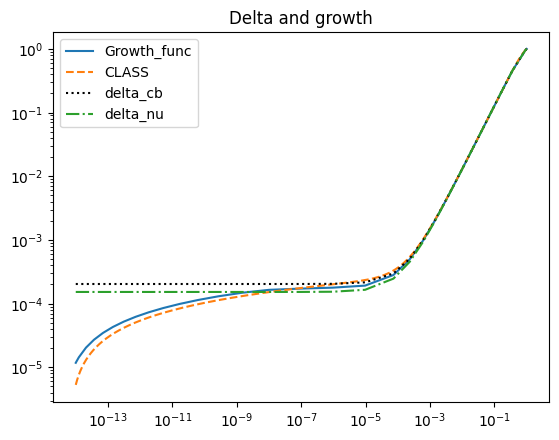

<Figure size 640x480 with 0 Axes>

In [8]:

aend = 1
a_class = 1/(1+ bg["z"])
a0 = a_class[0]

Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R
H0 = 70 / (3*1e5) # i 1/Mpc

def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

def f(a,y):
    #a = t
    tau = y[0]
    d_tau = 1 / (a ** 2 * H(a))
    return np.array(d_tau)

tau0 = (1/H0) * (Omega_R ** (-0.5)) * a0
sol1 = sc.solve_ivp(f,t_span=[a0,aend],y0=[tau0])

tau =sol1.y[0]
C = 1
k = 1
cs = 0
R_nu = 0

psi = 20 * C / (15 + 4 * R_nu)
theta_nu_0 =  0.5 * (k*k*tau[0]) * psi
theta_cb_0 = theta_nu_0 
delta_gamma = -2 * psi 
delta_nu_0 =delta_gamma
delta_cb_0 = 4/3 * delta_gamma
phi = psi * (1 + R_nu)


def f1(t,y):
    # kun cdm så cs = 0
    # her er t = tau
    a = y[0]
    D = y[1]
    D_dt = y[2]
    delta_cb = y[3]
    theta_cb = y[4]
    delta_nu = y[4]
    theta_nu = y[6]
    #print(t)
    a_dt = a * a * H(a)
        
    Omega_M_reel = Omega_M / ( a**3 * Omega_lambda + Omega_M + Omega_R / a)
    
    nabla2phi = ( 3 / 2 ) * H0 * H0 * Omega_M * (delta_cb+ delta_nu) / a # 
    
    D2_dt2 = +  ((3 / 2) * H0 * H0 * Omega_M * D / a) - a * H(a) * D_dt 
    
    delta_cb_dt = - theta_cb
    
    theta_cb_dt = -  a * H(a) * theta_cb - nabla2phi 
    
    delta_nu_dt = - theta_nu
    
    theta_nu_dt = -  a * H(a) * theta_nu - nabla2phi - k*k * (cs*cs ) * delta_nu
    
    return [a_dt,D_dt,D2_dt2,delta_cb_dt,theta_cb_dt,delta_nu_dt,theta_nu_dt]



t_start = tau[0]
t_end = tau[-1]
a0= tau0*(H0) * (Omega_R ** (0.5))
tau_span = np.array([t_start,t_end])

D0 = 1e-14
D1 = H0*np.sqrt(Omega_R)

y0 = [H0*np.sqrt(Omega_R)*tau0, D0, D1 ,delta_cb_0,theta_cb_0,delta_nu_0,theta_nu_0]


sol = sc.solve_ivp(f1,t_span=tau_span,y0 = y0)

tau_end = bg['conf. time [Mpc]'][-1]

tau = sol.t
a = sol.y[0]
D = sol.y[1]
D_dt = sol.y[2]
#print(D/D[-1])
delta_cdm = sol.y[3]
theta_cdm = sol.y[4]
delta_nu = sol.y[5]
theta_nu = sol.y[6]

plt.loglog(a, D/D[-1], label='Growth_func')
D_class = bg['gr.fac. D']
plt.loglog(a_class, D_class, label='CLASS', ls='--')
plt.loglog(a,delta_cdm/delta_cdm[-1],label="delta_cb",ls=":",color="black")
plt.loglog(a,delta_nu/delta_nu[-1],label="delta_nu",ls="-.")
plt.legend()
plt.title("Delta and growth")
plt.figure(1231)
#plt.loglog(a,theta_cdm)
#print(bg.keys())
#print(cosmo)

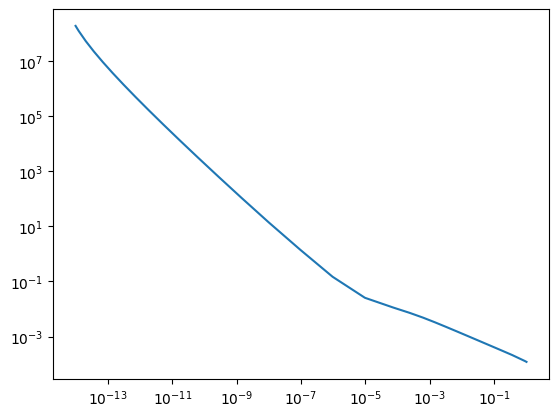

In [9]:
#print(-D_dt,len(D_dt))

#print(D,len(D))
#print(a,len(a))
plt.loglog(a,D_dt/D)

In [10]:
print(sol.y[1],len(sol.y[1]))


[1.00000000e-14 1.02215602e-14 1.22028828e-14 1.73236748e-14
 2.30371648e-14 2.94565902e-14 3.65224065e-14 4.42798085e-14
 5.27987930e-14 6.21780901e-14 7.25389632e-14 8.40180175e-14
 9.67431330e-14 1.10753774e-13 1.25724757e-13 1.39868083e-13
 1.46237263e-13 1.51352262e-13 1.62986117e-13 2.39174247e-13
 4.20134066e-13 8.33182335e-13 1.73731384e-12 3.71094338e-12
 8.00706024e-12 1.73547059e-11 3.76896894e-11 8.19208133e-11
 1.78052352e-10 3.85345894e-10 7.99391906e-10 8.49303209e-10] 32


In [11]:
"""from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
#plt.rcParams.update({   "text.usetex"
cosmo = Class()
cosmo.set({'H0':70, 'Omega_b':0.05, 'Omega_cdm':0.25})
cosmo.compute()
bg = cosmo.get_background()

Omega_M = 0.3
H0 = 70./3e5 #Mpc^-1
Omega_R = 7e-5
Omega_lambda = Omega_M - Omega_R


tau0 =  bg['conf. time [Mpc]'][0]
tau_end = bg['conf. time [Mpc]'][-1]

C = 0.31
k = 1
cs = 0.01
R_nu = 0
#print(H)
a_class = 1/(1 + bg['z'])
a0 = a_class[0]
aend = 1
def f(a,y):
    #a = t
    tau = y[0]
    d_tau = 1 / (a ** 2 * H(a))
    return np.array(d_tau)

tau0 = (1/H0) * (Omega_R ** (-0.5)) * a0

sol1 = sc.solve_ivp(f,t_span=[a0,aend],y0=[tau0])#,t_eval=a2) 

tau =sol1.y[0]

psi = 20 * C / (15 + 4 * R_nu)
theta_nu_0 =  0.5 * (k*k*tau0) * psi
theta_cb_0 = theta_nu_0 
delta_gamma = -2 * psi 
delta_nu_0 = delta_gamma
delta_cb_0 = 4/3 * delta_gamma
phi = psi * (1 + R_nu)
#,delta_nu_0,theta_nu_0])


def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 


def f(t, y):
    a = y[0]
    D = y[1]
    D_dt = y[2]
    delta_cb = y[3]
    theta_cb = y[4]
    
    a_dt = a * a * H(a)
    
    nabla2phi = ( 3 / 2 ) * H0 * H0 * Omega_M * (delta_cb) / a
    
    D2_dt2 = +  ((3 / 2) * H0 * H0 * Omega_M * D / a) - a * H(a) * D_dt
    
    
    delta_cb_dt = - theta_cb
    
    theta_cb_dt = -  a * H(a) * theta_cb - nabla2phi 
    
    return [a_dt,D_dt,D2_dt2,delta_cb_dt,theta_cb_dt]

#    H = H0*np.sqrt(Omega_R/a**4 + Omega_M/a**3 + (1 - Omega_M))
    
    
#    D2_dt2 = 1.5*H0*H0*Omega_M*D/a - a*H*D_dt
    
#    return [a*a*H, D_dt, D2_dt2]

y0 = [H0*np.sqrt(Omega_R)*tau0, 0, H0*np.sqrt(Omega_R),delta_cb_0,theta_cb_0]
sol = sc.solve_ivp(f, [tau0, tau_end], y0)
plt.loglog(sol.y[0], sol.y[1]/sol.y[1][-1], label='min kode')
a = 1/(1 + bg['z'])
D = bg['gr.fac. D']
plt.loglog(a, D, label='CLASS', ls='--')
plt.legend()"""

'from classy import Class\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom math import sqrt\nimport scipy.integrate as sc\n#plt.rcParams.update({   "text.usetex"\ncosmo = Class()\ncosmo.set({\'H0\':70, \'Omega_b\':0.05, \'Omega_cdm\':0.25})\ncosmo.compute()\nbg = cosmo.get_background()\n\nOmega_M = 0.3\nH0 = 70./3e5 #Mpc^-1\nOmega_R = 7e-5\nOmega_lambda = Omega_M - Omega_R\n\n\ntau0 =  bg[\'conf. time [Mpc]\'][0]\ntau_end = bg[\'conf. time [Mpc]\'][-1]\n\nC = 0.31\nk = 1\ncs = 0.01\nR_nu = 0\n#print(H)\na_class = 1/(1 + bg[\'z\'])\na0 = a_class[0]\naend = 1\ndef f(a,y):\n    #a = t\n    tau = y[0]\n    d_tau = 1 / (a ** 2 * H(a))\n    return np.array(d_tau)\n\ntau0 = (1/H0) * (Omega_R ** (-0.5)) * a0\n\nsol1 = sc.solve_ivp(f,t_span=[a0,aend],y0=[tau0])#,t_eval=a2) \n\ntau =sol1.y[0]\n\npsi = 20 * C / (15 + 4 * R_nu)\ntheta_nu_0 =  0.5 * (k*k*tau0) * psi\ntheta_cb_0 = theta_nu_0 \ndelta_gamma = -2 * psi \ndelta_nu_0 = delta_gamma\ndelta_cb_0 = 4/3 * delta_gamma\nphi = psi * (1

In [12]:
pts = cosmo.get_perturbations()
print(pts)

{'scalar': [{'tau [Mpc]': array([7.00928903e-01, 7.00929033e-01, 7.00929164e-01, ...,
       1.31808727e+04, 1.37374591e+04, 1.38941264e+04]), 'a': array([1.51409221e-06, 1.51409250e-06, 1.51409278e-06, ...,
       8.52136059e-01, 9.64422762e-01, 1.00000000e+00]), 'delta_g': array([-1.20436025, -1.20436026, -1.20436026, ..., -0.16960011,
       -0.16077165, -0.15799903]), 'theta_g': array([ 2.10381322e-03,  2.10381361e-03,  2.10381400e-03, ...,
       -1.79412551e-07, -1.53949487e-07, -1.47223611e-07]), 'shear_g': array([3.46088550e-09, 3.46088744e-09, 3.46088938e-09, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'pol0_g': array([8.65221376e-09, 8.65221860e-09, 8.65222344e-09, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'pol1_g': array([8.00655331e-16, 8.00656078e-16, 8.00656825e-16, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'pol2_g': array([1.73044275e-09, 1.73044372e-09, 1.73044469e-09, ...,
       0.00000000e+00, 0.00000000e+00, 